# People Chart Dataset Preparing of SapJam Topic "ChatBot"
Dataset file: People entities generate nodes and links

In [27]:
import json
import numpy as np
import pandas as pd

from pandas import DataFrame
from sqlalchemy import create_engine, distinct
from sqlalchemy.orm import sessionmaker

from JamScrapy import config
from JamScrapy.preprocess.entity import Profile, People

In [28]:
TOPIC_KEYWORD = 'ChatBot'
POSTS_THRESHOLD = 2
LINKS_THRESHOLD = 21

engine = create_engine(config.DB_CONNECT_STRING, max_overflow=5)

## 1. Dataset Preparing
### 1.1 Get Profiles by certain topic

In [29]:
sql = f'''select profile.* from (select displayname from jam_people_from_post
where keyword='{TOPIC_KEYWORD}' and roletype='Creator' and jam_people_from_post.displayname <> 'Alumni' 
group by jam_people_from_post.displayname having count(postid) >= {POSTS_THRESHOLD}) as people inner join jam_profile as profile
on people.displayname = profile.displayname'''

profiles = engine.execute(sql).fetchall()

print("profiles:", len(profiles))

#Jack Wang
#Swati Singh

profiles: 479


### 1.2 Get top contribution people

In [30]:
df_contribution = pd.read_csv(filepath_or_buffer='./output/contributes-chatbot.csv')

print(df_contribution.index)
print(df_contribution.columns)
print(df_contribution.shape)
df_contribution.describe(exclude=[np.object]).astype(np.int64).T

RangeIndex(start=0, stop=109, step=1)
Index(['Unnamed: 0', 'author', 'posts', 'comments', 'likes', 'views',
       'posts_trans', 'comments_trans', 'likes_trans', 'views_trans',
       'contribution'],
      dtype='object')
(109, 11)


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,109,54,31,0,27,54,81,108
posts,109,8,6,5,5,6,9,46
comments,109,9,6,0,6,7,9,47
likes,109,5,10,0,0,1,7,73
views,109,569,1026,25,82,176,731,8067
posts_trans,109,1,0,1,1,1,2,3
comments_trans,109,2,0,0,1,1,2,3
likes_trans,109,0,1,0,0,0,1,4
views_trans,109,5,1,3,4,5,6,8
contribution,109,73,8,62,67,73,77,100


## 2. Generate chart links

In [31]:
def add_link(list, filters, str, source=None, target=None, ban=False):
    if str:
        jsons = json.loads(str)
        if not ban or ban and (len(jsons) < LINKS_THRESHOLD):
            for item in jsons:
                name = item['name']               
                if (name in filters) and (name not in ['Francis Lui']):
                    if source is not None:
                        list.append({"source": source, "target": name})
                    elif target is not None:
                        list.append({"source": name, "target": target})

In [32]:
filters = [p.displayname for p in profiles]

links = []
for p in profiles:
    add_link(links, filters, p.managers, target=p.displayname)
    add_link(links, filters, p.reports, source=p.displayname)
    add_link(links, filters, p.followers, target=p.displayname, ban=True)
    add_link(links, filters, p.following, source=p.displayname, ban=True)

# 去掉重复节点
links = [dict(t) for t in set([tuple(d.items()) for d in links])]

print(len(links))

with open("./output/links.json",'w',encoding='utf-8') as json_file:
    json.dump(links,json_file,ensure_ascii=False)

304


In [33]:
nodes_degree = dict()

for l in links:
    if l['source'] not in nodes_degree:
        nodes_degree[l['source']] = 1
    else:
        nodes_degree[l['source']] += 1

    if l['target'] not in nodes_degree:
        nodes_degree[l['target']] = 1
    else:
        nodes_degree[l['target']] += 1
        
print(len(nodes_degree))

256


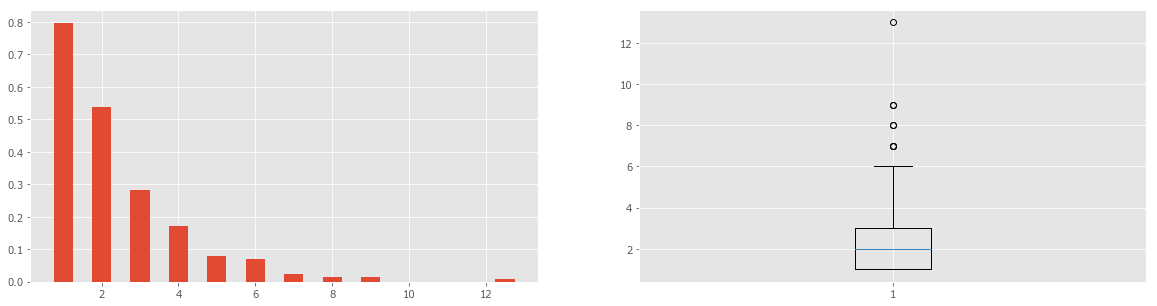

In [34]:
import matplotlib.pyplot as plt

degree = [v for v in nodes_degree.values()]

fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.hist(degree, bins=24, align='left', normed=True)
ax2.boxplot(degree)

plt.show()

## 3. Generate chart nodes

In [39]:
BROKERS = ['Steve Hamrick','Timo ELLIOTT','Soon Fuller','Lisa Munzenmaier','Maarten de Vries','Charles Tigges','Daniel Dahlmeier','Pushkar Ranjan','Mike Fecek']
INFLUENCERS = ['Anna Sahagun','Jayne Landry','Gail Moody-Byrd','Alexis Luna','Christian Lieske','Renee Wilhelm','Alfred Wu','Silvia Gao']

In [40]:
nodes = []

for p in profiles:
    ## 设置value和节点大小，依据contribution
    value = 0
    symbol_size = 5
    
    item = df_contribution[df_contribution['author']==p.displayname]    
    if item.size > 0:
        value = round(float(item['contribution']),2)
        symbol_size = int(item['contribution']/6)
        
    ## 设置category，依据degree
    categroy = 0
    
    if p.displayname in nodes_degree:
        if p.displayname in BROKERS:
            categroy = 3
        elif p.displayname in INFLUENCERS:
            categroy = 2
        elif nodes_degree[p.displayname] >= 6:
            categroy = 1
           
    nodes.append({"name": p.displayname, "value": value, "symbolSize": symbol_size, "category": categroy, "username": p.username, 
                     'profileurl': p.profileurl})

# 去掉重复节点
nodes = [dict(t) for t in set([tuple(d.items()) for d in nodes])]
nodes.remove({'name': 'Jack Wang', 'value': 69.53, 'symbolSize': 11, 'category': 0, "username": 'I058164', 
              'profileurl': 'https://jam4.sapjam.com/profile/wall/2U9XbycPlKQmw0GIN5NbuC'})
nodes.remove({'name': 'Swati Singh', 'value': 0, 'symbolSize': 5, 'category': 0, 'username': 'I341887', 
             'profileurl': 'https://jam4.sapjam.com/profile/wall/1jJeRdCEuVk829XcGtIRc3'})

print(len(nodes))

with open("./output/nodes.json",'w',encoding='utf-8') as json_file:
    json.dump(nodes,json_file, ensure_ascii=False)

477


In [41]:
for p in nodes:
    if p['name'] in ['Jack Wang','Swati Singh']:
        print(p)

{'name': 'Swati Singh', 'value': 0, 'symbolSize': 5, 'category': 0, 'username': 'I856280', 'profileurl': 'https://jam4.sapjam.com/profile/wall/ewSylUDp7BMc5Ikud6VQcg'}
{'name': 'Jack Wang', 'value': 69.53, 'symbolSize': 11, 'category': 0, 'username': 'I067257', 'profileurl': 'https://jam4.sapjam.com/profile/wall/2XcrHYYeCEX3xHKjK9Ds55'}


In [42]:
matrix = dict()
threshold = 75

for item in nodes:   
    if item['category'] == 0 and item['value'] <= threshold:
        character = "Thinkers"
    elif item['category'] == 0 and item['value'] > threshold:
        character = "Pioneers"
    elif item['category'] == 1 and item['value'] <= threshold:
        character = "Delegators"
    elif item['category'] == 1 and item['value'] > threshold:
        character = "Generators"
    elif item['category'] == 2 and item['value'] <= threshold:
        character = "Enablers"
    elif item['category'] == 2 and item['value'] > threshold:
        character = "Teamsters"
    elif item['category'] == 3 and item['value'] <= threshold:
        character = "Broadcasters"
    elif item['category'] == 3 and item['value'] > threshold:
        character = "Definers"

    if character not in matrix:
        matrix[character] = 1
    else:
        matrix[character] += 1

print('Thinkers', matrix['Thinkers'], 'Pioneers', matrix['Pioneers'])
print('Delegators', matrix['Delegators'], 'Generators', matrix['Generators'])
print('Enablers', matrix['Enablers'], 'Teamsters', matrix['Teamsters'])
print('Broadcasters', matrix['Broadcasters'], 'Definers', matrix['Definers'])


Thinkers 416 Pioneers 33
Delegators 9 Generators 2
Enablers 3 Teamsters 5
Broadcasters 7 Definers 2


# 4. Generate Nodes group by division

In [24]:
FIELD_GROUP_BY = 'localinfo'
data_view = f'''select profile.*, p_profile.{FIELD_GROUP_BY} from (select displayname from jam_people_from_post
where keyword='{TOPIC_KEYWORD}' and roletype='Creator' and jam_people_from_post.displayname <> 'Alumni'
group by jam_people_from_post.displayname having count(postid) >= {POSTS_THRESHOLD}) as people
inner join jam_profile as profile on people.displayname = profile.displayname
inner join portal_profile as p_profile on profile.username = p_profile.username'''
sql = f'''select {FIELD_GROUP_BY}, count(id) from ({data_view}) as t group by t.{FIELD_GROUP_BY} order by t.{FIELD_GROUP_BY}'''

In [26]:
results = engine.execute(sql).fetchall()

print(results)
for r in results:
    print(f'{{ "name": "{r[0]}"}},')

[(None, 27), ('Africa/Johannesburg', 1), ('America/Bogota', 2), ('America/Buenos_Aires', 1), ('America/Chicago', 19), ('America/Denver', 3), ('America/Los_Angeles', 64), ('America/New_York', 53), ('America/Phoenix', 1), ('America/Sao_Paulo', 5), ('America/Toronto', 9), ('America/Vancouver', 9), ('Asia/Calcutta', 14), ('Asia/Dubai', 1), ('Asia/Hong_Kong', 3), ('Asia/Jakarta', 1), ('Asia/Jerusalem', 2), ('Asia/Kuala_Lumpur', 1), ('Asia/Manila', 1), ('Asia/Seoul', 10), ('Asia/Shanghai', 17), ('Asia/Singapore', 14), ('Asia/Tokyo', 4), ('Australia/Melbourne', 2), ('Australia/Sydney', 3), ('Europe/Amsterdam', 3), ('Europe/Athens', 2), ('Europe/Berlin', 122), ('Europe/Brussels', 2), ('Europe/Copenhagen', 1), ('Europe/Dublin', 7), ('Europe/Helsinki', 2), ('Europe/Lisbon', 1), ('Europe/London', 22), ('Europe/Madrid', 5), ('Europe/Moscow', 2), ('Europe/Oslo', 2), ('Europe/Paris', 18), ('Europe/Rome', 4), ('Europe/Sofia', 1), ('Europe/Stockholm', 1), ('Europe/Warsaw', 2), ('Europe/Zurich', 10)]
{

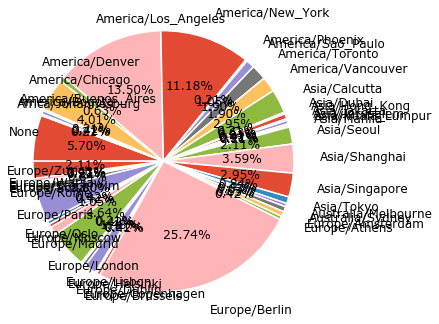

In [14]:
from utility import plt_pie

values = []
labels = []
for r in results:
    if int(r[1]) > 0:
        values.append(int(r[1]))
        labels.append(r[0])
        
plt_pie(values, labels)

In [15]:
query = engine.execute(data_view+f' order by {FIELD_GROUP_BY}')

print(query.keys())

profiles = query.fetchall()

print(len(profiles))
print(profiles[0].profileurl)
print(profiles[0].username)
print(profiles[0].displayname)

['id', 'profileurl', 'username', 'displayname', 'avatar', 'mobile', 'email', 'managers', 'reports', 'groups', 'followers', 'following', 'localinfo']
474
https://jam4.sapjam.com/profile/wall/OfdTTBvst8UzZ7BKIfTgsu
I312884
Ankitha Malalur Gopal


In [22]:
nodes = []

for p in profiles:
    if (p.displayname in nodes_degree.keys()):
        # 设置value和节点大小，依据contribution
        value = 0
        symbol_size = 5
        category = ''
        
        item = df_contribution[df_contribution['author']==p.displayname]
        if item.size > 0:
            value = round(float(item['contribution']),2)
            symbol_size = 5+int(item['contribution']/6)
            
        if p.localinfo == None:
            category = 'None'
        else:
            category = p.localinfo
        
        nodes.append({"name": p.displayname, "value": value, "symbolSize": symbol_size, "category": category, "username": p.username, 
                     'profileurl': p.profileurl})


# 去掉重复节点
nodes = [dict(t) for t in set([tuple(d.items()) for d in nodes])]
nodes.remove({'name': 'Jack Wang', 'value': 69.53, 'symbolSize': 16, 'category': 'Asia/Singapore', "username": 'I058164', 
              'profileurl': 'https://jam4.sapjam.com/profile/wall/2U9XbycPlKQmw0GIN5NbuC'})
nodes.remove({'name': 'Swati Singh', 'value': 0, 'symbolSize': 5, 'category': 'None', 'username': 'I341887', 
             'profileurl': 'https://jam4.sapjam.com/profile/wall/1jJeRdCEuVk829XcGtIRc3'})

nodes.sort(key = lambda x:x["category"])

print(len(nodes))

with open(f"./output/nodes-{FIELD_GROUP_BY}.json",'w',encoding='utf-8') as json_file:
    json.dump(nodes,json_file, ensure_ascii=False)

254


In [23]:
for p in nodes:
    if p['name'] in ['Jack Wang','Swati Singh']:
        print(p)

{'name': 'Swati Singh', 'value': 0, 'symbolSize': 5, 'category': 'America/New_York', 'username': 'I856280', 'profileurl': 'https://jam4.sapjam.com/profile/wall/ewSylUDp7BMc5Ikud6VQcg'}
{'name': 'Jack Wang', 'value': 69.53, 'symbolSize': 16, 'category': 'Asia/Shanghai', 'username': 'I067257', 'profileurl': 'https://jam4.sapjam.com/profile/wall/2XcrHYYeCEX3xHKjK9Ds55'}
